In [64]:
# Imports
%matplotlib inline


from My_Functions import * 
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from collections import defaultdict

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score,roc_curve
from sklearn.model_selection import train_test_split, KFold,StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict,validation_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.linear_model import SGDRegressor

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelBinarizer, RobustScaler,PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from scipy import stats
from scipy.stats import skew, boxcox_normmax
from scipy.special import boxcox1p

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator , MultipleLocator
##from matplotlib import XAxis

from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer,StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LogisticRegression,LinearRegression, OrthogonalMatchingPursuit
from sklearn.model_selection import train_test_split , TimeSeriesSplit, GridSearchCV 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from matplotlib.gridspec import GridSpec
import plotly.tools as tls
import plotly
plotly.tools.set_credentials_file(username='Furqan92', api_key='22DfVN5rFRg79OYygN5h')
import plotly.plotly as py
from sklearn.decomposition import PCA
from pandas import DataFrame 
from sklearn.exceptions import ConvergenceWarning
import warnings

warnings.simplefilter(action='ignore')
random_seed = 504
tscv = TimeSeriesSplit(n_splits=5)

In [65]:
# To automatically reload the function file 
%load_ext autoreload
%aimport My_Functions
%run My_Functions.py
%autoreload 1

In [2]:
# Load datasets
we_h=pd.read_csv('./weekends1_holi_data_prepared.csv')
we_h['dteday']=pd.to_datetime(we_h['dteday'], format='%Y-%m-%d')

In [3]:
hey1 = we_h.drop(np.arange(1,13).astype(str),axis =1)
hey2 = hey1.drop(['m_1', 'm_2','registered', 'casual',
       'm_3', 'm_4', 'm_5', 'm_6','h_16', 'h_17', 'h_18', 'h_19','yr' ,'h_20', 'h_21','h_9', 'h_10',
       'h_22', 'h_23','holiday', 'RushHour-Med','s_fall','m_7','w_Chaos', 'm_8', 'm_9','s_spring', 's_summer', 'm_10', 'm_11', 'm_12','w_0', 'w_1', 'w_2', 'w_3', 'w_4', 'w_5', 'w_6'],axis=1)

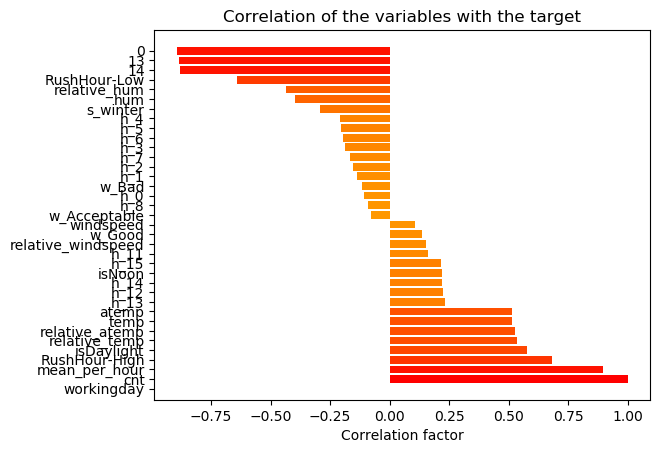

<Figure size 10000x6000 with 0 Axes>

In [4]:
hey = hey2.corr()['cnt'][:]
plt.rcdefaults()
fig, ax = plt.subplots()

import matplotlib.colors as mcolors
fig = plt.figure(figsize=(100,60))
# Example data
people = hey.sort_values().index
y_pos = np.arange(len(people))
performance = hey.sort_values()


cmap = mcolors.LinearSegmentedColormap.from_list("", ["orange", "red"])


ax.barh(y_pos, performance,  align='center', color=cmap(np.abs(performance)))
ax.set_yticks(y_pos)
ax.set_yticklabels(people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Correlation factor')
ax.set_title('Correlation of the variables with the target')

plt.show()

## Subset 2011 -> 2012Q3 Data

In [5]:
X_Train_2011_2012Q2 = we_h[we_h['dteday'] < datetime.datetime(2012, 7, 1, 0, 0)].drop(['cnt','casual','registered','dteday'],axis=1)## NONE OF THst_EM IN DATA
Y_cnt_train_2011_2012Q2 =we_h['cnt'][we_h['dteday'] < datetime.datetime(2012, 7, 1, 0, 0)]

X_Test_2012Q3 = we_h[(we_h['dteday'] >= datetime.datetime(2012, 7, 1, 0, 0)) & (we_h['dteday'] <= datetime.datetime(2012, 9, 30, 0, 0))].drop(['cnt','casual','registered','dteday'],axis=1)## NONE OF THEM IN DATA
Y_cnt_test_2012Q3 =we_h['cnt'][(we_h['dteday'] >= datetime.datetime(2012, 7, 1, 0, 0)) & (we_h['dteday'] <= datetime.datetime(2012, 9, 30, 0, 0))]


## Linear regression w/ GS for *Weekends* for 2011 -> 2012Q3

In [6]:
##Linear Regression
lm_parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True]}

lm = GridSearchCV(LinearRegression(),
                                 param_grid=lm_parameters,
                                 cv=tscv,return_train_score=True)

lm.fit(X_Train_2011_2012Q2, Y_cnt_train_2011_2012Q2)
# lm.cv_results_
lm_predictions = lm.predict(X_Test_2012Q3)
lm.score(X_Test_2012Q3, Y_cnt_test_2012Q3)

0.833325057136417

## Random Forest w/ GS for *weekends* for 2011 -> 2012Q3

In [7]:
RF_parameters = {'n_estimators': [10, 30 ,40,100],
                                             'bootstrap': [True ,False],
                                             'max_depth': [80, 100 ,120 ],
                                             'max_features': ['log2', 16, 32 ],
                                             'min_samples_leaf': [2,  5 , 8],
                                             'min_samples_split': [ 10 , 8 , 15 , 18],
                                            'random_state':[random_seed],
                                            'criterion':['mse']}
rf = GridSearchCV(RandomForestRegressor(),
                                 param_grid= RF_parameters,
                                 cv=tscv)

rf.fit(X_Train_2011_2012Q2, Y_cnt_train_2011_2012Q2)
# rf.cv_results_
rf_predictions = lm.predict(X_Test_2012Q3)
rf.score(X_Test_2012Q3, Y_cnt_test_2012Q3)

0.8570826212022598

## K Nearest Neighbors regressor w/ GS for *Weekends* for 2011 -> 2012Q3

In [8]:
knn_parameters = {'n_neighbors':[1, 5,10,15, 30 ],'weights':['uniform'], 'algorithm':['auto'],'leaf_size':[5 ,10, 20,30],
                  'p':[1,2,3],'metric':['minkowski']}
knn = GridSearchCV(KNeighborsRegressor(),
                                 param_grid=knn_parameters,
                                 cv=tscv,return_train_score=True)
knn.fit(X_Train_2011_2012Q2, Y_cnt_train_2011_2012Q2)
# rf.cv_results_
knn_predictions = knn.predict(X_Test_2012Q3)
knn.score(X_Test_2012Q3, Y_cnt_test_2012Q3)

0.8169627172541623

## Support Vector regressor w/ GS for *Weekends* for 2011 -> 2012Q3

In [ ]:
# svr = GridSearchCV(SVR(), cv=tscv,
#                    param_grid={"kernel" : ['linear', 'rbf', 'poly'],
#                        "C": [1e0, 1e1, 1e2, 1e3],
#                                "gamma": np.logspace(-2, 2, 5)})

# svr.fit(X_Train_2011_2012Q2, Y_cnt_train_2011_2012Q2)
# # rf.cv_results_
# svr_predictions = svr.predict(X_Test_2012Q3)
# svr.score(X_Test_2012Q3, Y_cnt_test_2012Q3)

## XGBoost regressor w/ GS for *Weekends* for 2011 -> 2012Q3

In [9]:


param_grid = {'learning_rate': [0.01, 0.1], 
          'max_depth': [4,8,12],
          'min_child_weight': [3,5,10,20,35,50],
          'subsample': [0.5, 0.75],
          'colsample_bytree': [0.5, 0.75],
          'n_estimators': [100, 300],
              'random_state':[random_seed]
}

model = xgb.XGBRegressor()

xg = GridSearchCV(model,
                    param_grid = param_grid,
                    cv = tscv,
                    n_jobs = -1,
                    scoring = 'r2',
                    verbose=True)
xg.fit(X_Train_2011_2012Q2, Y_cnt_train_2011_2012Q2)
xg_predictions = xg.predict(X_Test_2012Q3)
xg.score(X_Test_2012Q3, Y_cnt_test_2012Q3)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed: 15.7min finished


0.8879889040783053

## Taking predictions from LR and Random Forest to test on 2012Q4

In [10]:
# LR and Random Forest predictions
combinedPredictions = pd.DataFrame({'lm_predictions':lm_predictions,'rf_predictions':rf_predictions,'xg_predictions':xg_predictions })

# Concat original data
X_Test_2012Q3.reset_index(drop=True,inplace=True)
combinedPredictions = pd.concat([combinedPredictions,X_Test_2012Q3], axis=1)

# Target data
combinedPredictionsTarget = pd.DataFrame({'target':Y_cnt_test_2012Q3})

#Reset indices
combinedPredictions.reset_index(drop=True,inplace=True)
combinedPredictionsTarget.reset_index(drop=True,inplace=True)

## Subset Q4 data and concat it with its level-0 predctions

In [11]:
#Get Q4 data
X_Test_Q4 = we_h[(we_h['dteday'] >= datetime.datetime(2012, 9, 30, 0, 0)) & (we_h['dteday'] <= datetime.datetime(2012, 12, 31, 0, 0))].drop(['cnt','casual','registered','dteday'],axis=1)## NONE OF THEM IN DATA
Y_cnt_test_Q4 =we_h['cnt'][(we_h['dteday'] >= datetime.datetime(2012, 9, 30, 0, 0)) & (we_h['dteday'] <= datetime.datetime(2012, 12, 31, 0, 0))]
oringal_cnt = Y_cnt_test_Q4

#get level-0 predictions for Q4 data
Q4_lm_predictions = pd.DataFrame(lm.predict(X_Test_Q4), columns=["lm_predictions"])
Q4_rf_predictions = pd.DataFrame(rf.predict(X_Test_Q4), columns=["rf_predictions"])
##Q4_knn_predications = pd.DataFrame(knn.predict(X_Test_Q4), columns=["knn_predications"])
Q4_xg_predictions = pd.DataFrame(xg.predict(X_Test_Q4), columns=["xg_predictions"])

X_Test_Q4.reset_index(drop=True,inplace=True)
Q4_lm_predictions.reset_index(drop=True,inplace=True)
Q4_rf_predictions.reset_index(drop=True,inplace=True)

Q4_xg_predictions.reset_index(drop=True,inplace=True)
Y_cnt_test_Q4.reset_index(drop=True,inplace=True)

#concat Q4 with level-0 predictions 
X_Test_Q4_with_predictions = pd.concat([Q4_lm_predictions, Q4_rf_predictions,Q4_xg_predictions,X_Test_Q4], axis=1)
Y_cnt_test_Q4 = pd.DataFrame({"target": Y_cnt_test_Q4})

## Q4 scores

In [12]:

lm.score(X_Test_Q4, Y_cnt_test_Q4)

0.8785830145250169

In [13]:
rf.score(X_Test_Q4, Y_cnt_test_Q4)

0.8496221562020154

In [14]:
knn.score(X_Test_Q4, Y_cnt_test_Q4)

0.7577913883377447

In [15]:
xg.score(X_Test_Q4, Y_cnt_test_Q4)

0.8905392281141818

## Train and test Q4

In [16]:


param_grid = {'learning_rate': [0.01, 0.1], 
          'max_depth': [4,8,12],
          'min_child_weight': [3,5,10,20,35,50],
          'subsample': [0.5, 0.75],
          'colsample_bytree': [0.5, 0.75],
          'n_estimators': [100, 300],
              'random_state':[random_seed]
}

model = xgb.XGBRegressor()

xg1 = GridSearchCV(model,
                    param_grid = param_grid,
                    cv = tscv,
                    n_jobs = -1,
                    scoring = 'r2',
                    verbose=True)

xg1.fit(combinedPredictions, combinedPredictionsTarget)
xg1_predictions = xg1.predict(X_Test_Q4_with_predictions)
xg1.score(X_Test_Q4_with_predictions, Y_cnt_test_Q4)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  2.6min finished


0.8580293752201731

In [ ]:
The score decreased drastically so after some research Stochastic Gradient Descent seemed like an appropriate model to try in stacking because it also act on errors using lasso and ridge and elastic net 
penalty and has learning rate , in fact it gave a better score then XGBoost but still not morew then the level 0 XGBoost 

### Stochastic Gradient Descent: tried after XGBoost 

In [17]:
# Grid search - this will take about 1 minute.
param_grid = {
    'alpha': 10.0 ** -np.arange(1, 7),
    'loss': ['squared_loss', 'huber', 'epsilon_insensitive'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'learning_rate': ['constant', 'optimal', 'invscaling'],
}
clf = GridSearchCV(SGDRegressor(), param_grid)
clf.fit(combinedPredictions, combinedPredictionsTarget)
clf_predictions = clf.predict(X_Test_Q4_with_predictions)
clf.score(X_Test_Q4_with_predictions, Y_cnt_test_Q4)


0.8801300973656445

we saw that our score decreased after the stacking so it seemed appropriate to go with the XGBoost level 0 model 
(This was not mentioned in the presentation because a random seed wasnt fixed )


In [177]:
work_predictions=pd.read_csv('pred_working.csv')
work_predictions.columns = ['dteday','prediction','target']

In [178]:
not_work_predictions = pd.concat((pd.DataFrame(xg.predict(X_Test_Q4)) , Y_cnt_test_Q4), axis=1)
not_work_predictions.columns = ['prediction','target']

In [179]:
print('The last r2 score for the predictions is :')
r2score(np.concatenate((not_work_predictions['target'],
                         work_predictions['target'])),
         np.concatenate((not_work_predictions['prediction'],
                         work_predictions['prediction'])) )

The last r2 score for the predictions is :


0.8970919438033946

In [180]:
date = we_h['dteday'][(we_h['dteday'] >= datetime.datetime(2012, 9, 30, 0, 0)) & (we_h['dteday'] <= datetime.datetime(2012, 12, 31, 0, 0))]
date=pd.to_datetime(date, format='%Y-%m-%d')
date.reset_index(drop=True,inplace=True)
work_predictions.reset_index(drop=True,inplace=True)
not_work_predictions=pd.concat([date,not_work_predictions],axis=1)


In [181]:
work_predictions.set_index('dteday')
not_work_predictions.set_index('dteday')

combined=work_predictions.append(not_work_predictions)

In [182]:
df = combined.melt('dteday', var_name='cols',  value_name='vals')
df["dteday"]=df["dteday"].map(lambda x:  pd.to_datetime(x))
mpl_fig = plt.figure()
ax= plt.axes()

sns.lineplot(x="dteday", y="vals", hue='cols', data=df)

plotly_fig=tls.mpl_to_plotly(mpl_fig)
plotly_fig['layout']['xaxis'] = {
   'tickmode': 'auto',
   'nticks': 3
    }
plotly_fig['layout']['showlegend'] = False
plotly_fig['layout'] = {'width':800}
plotly_fig['layout']['title'] = 'Predictions'
py.iplot(plotly_fig,filename='Predictions')